# Cause-of-Death Mortality Modeling with Neural Network
In this file, we will test different architectures to model cause-of-death mortality data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, BatchNormalization, Dropout, Concatenate
from keras.utils import plot_model

## Import dataset
Huidige gebruikte data: 
    
    - Country: USA
    - Years: 1979-2021
    - List: Short list, reconstructed (16 causes)
    - Death rates omgezet naar juiste mortality rates (delen door 1,000,000)
    - Sex: geen opsplitsing op gender
    
Data processing: omzetting naar dataframe met kolommen country, year, cause, age, m, log_m


In [19]:
MYwd= os.getcwd()
file_path = MYwd+r"\Data\cause_specific_Short_Reconstructed\USA_m_short_idr.csv"          # short list
#file_path = MYwd+r"\Data\cause_specific_Interm_Reconstructed\USA_m_interm_idr.csv"       #intermediate list
#file_path = MYwd+r"\Data\cause_specific_Long_Reconstructed\USA_m_long_idr.csv"        # long list

data = pd.read_csv(file_path)

# deel door 1,000,000 om force of mortality te krijgen
exclude_cols = ['country', 'year', 'sex', 'list', 'agf', 'cause']
data.loc[:, ~data.columns.isin(exclude_cols)] = data.loc[:, ~data.columns.isin(exclude_cols)] / 1000000

# only keep the lines for both sexes: 
subset = data[data['sex'] == 3]
subset = subset.drop(columns=['sex', 'list', 'agf', 'total', 'm85p', 'm90p', 'm95p'])

# nu staat de data in de vorm: country, year, cause, m0, m1, m5, ...
# ik wil de vorm: country, year, cause, age, m

df = subset.melt(id_vars=['country', 'year', 'cause'], var_name='age', value_name='m')
df['age'] = df['age'].str.extract('(\d+)').astype(int)                           # Convert 'age' from 'mX' format to just 'X'
df['log_m'] = np.log(df['m'].replace(0,1e-8))                                    # add log mortality, avoid taking log(0)

# Prepare data to feed into neural network: 
df['cause'] = df['cause'].astype('category').cat.codes      # convert to categorical variable

df['year'] = df['year'].astype('float')    # neural nets prefer floats over ints
df['age'] = df['age'].astype('float')

# Division in training and test set

In [20]:
 # Set up the training set
train = df[(df['year'].between(1979, 2011))]
train = train.copy() 

test_set = df[(df['year'].between(2012, 2021))]
test_set = test_set.copy()

# Custom activation functions

In [21]:
# custom activation function that maps values to range [-infty, 0]

def log_sigmoid(x):
    return tf.math.log_sigmoid(x)

def negative_softplus(x):
    return -tf.math.softplus(x)

def negative_relu(x):
    return tf.minimum(0.0, x)

def scaled_log_sigmoid(x):
    return (1/5.55) * tf.math.log_sigmoid(x)

## Neural Network Model

In [22]:
from keras.callbacks import Callback

class PrintSomeEpochs(Callback):
    def __init__(self, print_every=5):  # Customize frequency
        self.print_every = print_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every == 0:  # Print every N epochs
            print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}")

# Attach callback to training
print_callback = PrintSomeEpochs(print_every=10)  # Print every 10 epochs

In [23]:
year_mean, year_std = train['year'].mean(), train['year'].std()
age_mean, age_std = train['age'].mean(), train['age'].std()


In [24]:
def prepare_input_data(data):
    # Extract unique combos of 'year' and 'age'
    unique_combos = data[['year', 'age']].drop_duplicates()
    
    # Reshape inputs and set to numpy arrays
    year = np.array(unique_combos['year'].values.reshape(-1,1))
    age = np.array(unique_combos['age'].values.reshape(-1,1))
    
    #year_mean, year_std = year.mean(), year.std()
    #age_mean, age_std = age.mean(), age.std()
    
    year_norm = (year - year_mean) / year_std
    age_norm = (age - age_mean) / age_std
    
    X = [year_norm, age_norm]
    
    ncauses = len(data['cause'].drop_duplicates())
    rows = len(data['log_m'].values) // ncauses          
    Y = data['log_m'].values.reshape(rows, ncauses)      

    
    return X, Y

In [25]:
#############################
### Set up neural network ###
#############################


def build_model(units=np.array([256, 256]), ncauses=17, activation = 'relu', drop=0.2, learning_rate=0.001):
    # Define the input layers
    year = Input(shape=(1,), dtype='float32', name='year')
    age = Input(shape=(1,), dtype='float32', name='age')
    
    # Concatenate the defined features
    features = Concatenate()([year, age])
    
    x = Dense(units=units[0], activation=activation)(features)
    x = BatchNormalization()(x)
    x = Dropout(drop)(x)
    
    # Define the hidden layers
    for i in range(1, len(units)): 
        x = Dense(units=units[i], activation=activation)(x)
        x = BatchNormalization()(x)
        x = Dropout(drop)(x)
    
    # Define the output layer
    target = Dense(units=ncauses, activation='linear')(x)      
    
    model = Model(inputs=[year, age], outputs=target)
    
    Adam_optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=Adam_optimizer, loss='mse', metrics=['mae'])
    
    return model

### Train the Neural Network

In [9]:
# training the model
#model = build_model()
# optimal architecture: 
ncauses = len(train['cause'].drop_duplicates())
model = build_model(units=np.array([500, 256, 128, 128]), ncauses=ncauses)


X_train, Y_train = prepare_input_data(train)

epochs = 10
batch = 64
#history = model.fit(x=X_train, y=Y_train, batch_size=batch, epochs=epochs, verbose=1, validation_split=0.1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=100, verbose=1, restore_best_weights=True)
history = model.fit(x=X_train, y=Y_train, batch_size=batch, epochs=epochs, verbose=1, callbacks=[earlystop])


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 196.8494 - mae: 13.4709
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 191.9214 - mae: 13.3699
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 192.0344 - mae: 13.4525
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 186.9342 - mae: 13.2716
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 186.9291 - mae: 13.2856
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 182.3066 - mae: 13.0955
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 181.5461 - mae: 13.0698
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 175.9841 - mae: 12.8542
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 167.7616 - mae: 12.5232
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 160.6769 - mae: 12.2396
Restoring model weights from the end of the best epoch: 10.


In [26]:
# save the model
#model.save("NNmodelCauseOfDeathLong.keras")
#loaded_model = tf.keras.models.load_model("NNmodelCauseOfDeath.keras")


ncauses = len(train['cause'].drop_duplicates())
X_train, Y_train = prepare_input_data(train)
model = tf.keras.models.load_model("NNmodelCauseOfDeath.keras")


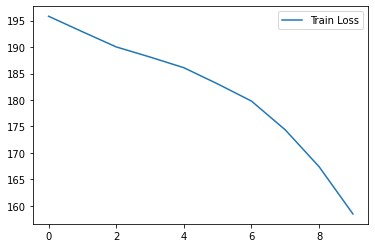

In [27]:
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


### Test the Network on unseen data

#### Remove covid years from test set (! short list)
cause 10: 2020 and 2021 --> data is replaced by the data of 2019


In [28]:
if ncauses == 17:    # this only holds for the short list
    
    cause10_2019 = test_set[(test_set['cause'] == 10) & (test_set['year'] == 2019)]['log_m'].values

    # replace data in 2020 and 2021 by the data of 2019
    test_set.loc[(test_set['cause'] == 10) & (test_set['year'] == 2020), 'log_m'] = cause10_2019
    test_set.loc[(test_set['cause'] == 10) & (test_set['year'] == 2021), 'log_m'] = cause10_2019

    #covid = test_set[(test_set['cause'] == 10)]
    #plt.scatter(covid['age'], covid['log_m'])
    

In [29]:
X_test, Y_test = prepare_input_data(test_set)

score = model.evaluate(X_test, Y_test, verbose=0)
print(model.metrics_names)
print(f'Test set: {score}')

# score on training set:
score_train = model.evaluate(X_train, Y_train, verbose=0)
print(f'Training set: {score_train}')


# predictions on the test set: 
predic = model.predict(X_test)
test_set['prediction'] = predic.reshape(-1,1)


['loss', 'compile_metrics']
Test set: [0.16994298994541168, 0.2788783609867096]
Training set: [0.11471221596002579, 0.20435720682144165]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [41]:
# Save to excel
#test_set.to_excel('predictions_NN_Short.xlsx', index=False)

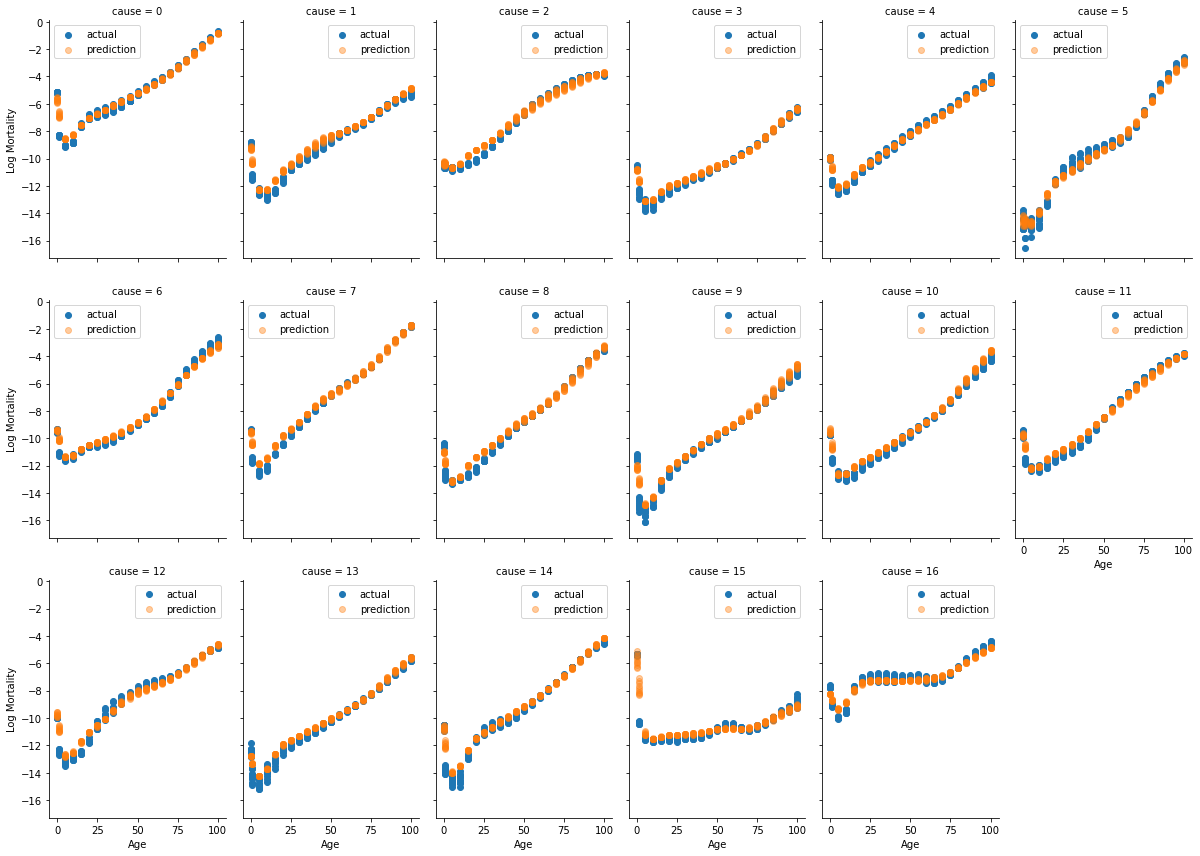

In [31]:
# goodness of fit on plot
g = sns.FacetGrid(test_set, col='cause', palette='mako',
                  margin_titles=True, height=4, aspect=0.7, col_wrap=6)

g.map(sns.scatterplot, 'age', 'log_m', s=20)

# Adjust the title, legend, and axis formatting
g.set_axis_labels("Age", "Log Mortality")


for ax, (_, subset) in zip(g.axes.flat, test_set.groupby(['cause'])):
    scatter = ax.scatter(subset['age'], subset['log_m'], label='actual')
    ax.scatter(subset['age'], subset['prediction'], label='prediction', alpha=0.4)
    ax.legend()

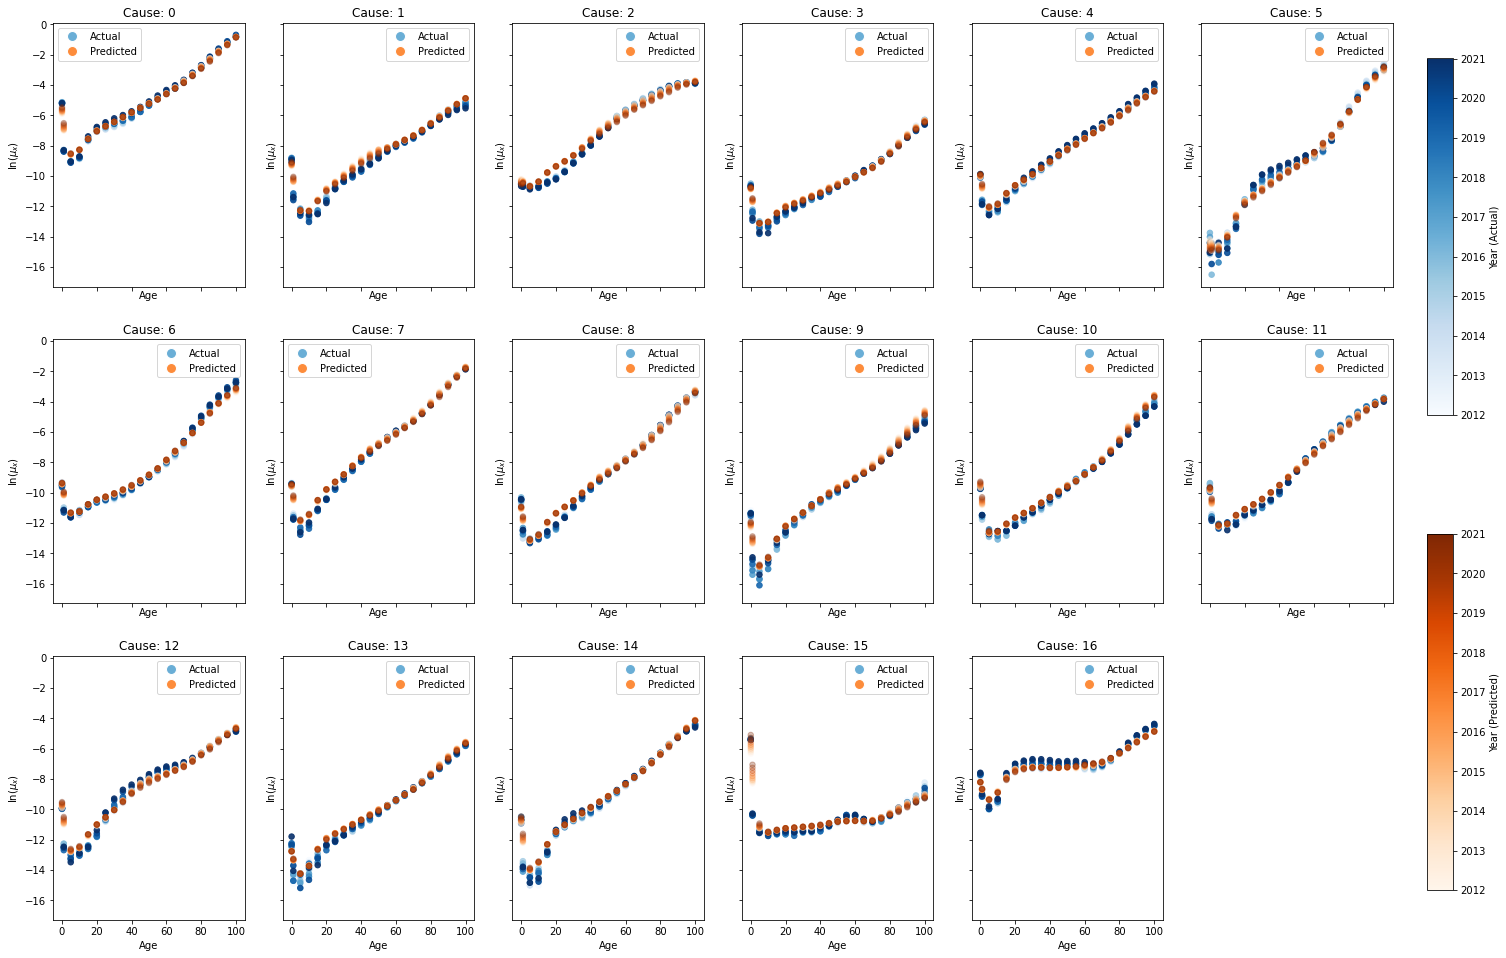

In [40]:
### Mooier plotje (danku chatgpt) ###
#####################################

# Unique causes and color normalization
causes = test_set['cause'].unique()
num_causes = len(causes)

# Set up grid
cols = 6
rows = int(np.ceil(num_causes / cols))
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4 * cols, 5.5 * rows), sharex=True, sharey=True)
axes = axes.flatten()

# Color maps
cmap_blue = sns.color_palette("Blues", as_cmap=True)
cmap_red = sns.color_palette("Oranges", as_cmap=True)
year_min, year_max = test_set['year'].min(), test_set['year'].max()
norm = plt.Normalize(year_min, year_max)

# Plotting loop
for ax, cause in zip(axes, causes):
    cause_data = test_set[test_set['cause'] == cause]

    # Actual values
    ax.scatter(cause_data['age'], cause_data['log_m'],
               c=[cmap_blue(norm(y)) for y in cause_data['year']],
               s=30, alpha=0.9,label='Actual')

    # Predicted values
    ax.scatter(cause_data['age'], cause_data['prediction'],
               c=[cmap_red(norm(y)) for y in cause_data['year']],
               s=30, alpha=0.3, label='Predicted')

    ax.set_title(f"Cause: {cause}")
    ax.set_xlabel("Age")
    ax.set_ylabel(r"$\ln(\mu_x)$")
    ax.legend(loc='upper right')
    
    legend_markers = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_blue(norm((year_max+year_min)/2)), markersize=10, label="Actual"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_red(norm((year_max+year_min)/2)), markersize=10, label="Predicted")
    ]
    ax.legend(handles=legend_markers)

# Remove extra axes
for i in range(len(causes), len(axes)):
    fig.delaxes(axes[i])

# Colorbars
cbar_ax_blue = fig.add_axes([0.92, 0.55, 0.015, 0.3])
sm_blue = plt.cm.ScalarMappable(cmap=cmap_blue, norm=norm)
fig.colorbar(sm_blue, cax=cbar_ax_blue, label="Year (Actual)")

cbar_ax_red = fig.add_axes([0.92, 0.15, 0.015, 0.3])
sm_red = plt.cm.ScalarMappable(cmap=cmap_red, norm=norm)
fig.colorbar(sm_red, cax=cbar_ax_red, label="Year (Predicted)")

plt.show()


In [33]:
causes = test_set['cause'].drop_duplicates()
overall_mse = mean_squared_error(test_set['log_m'], test_set['prediction'])

print(f'Overall mse: {overall_mse}')

mse_df = pd.DataFrame(columns=['Cause', 'mse_nn'])
index = 0

for cause in causes:
    
    subset = test_set[test_set['cause'] == cause]
    mse = mean_squared_error(subset['log_m'], subset['prediction'])
    
    mse_df.loc[index] = [cause, mse]
    index += 1

mse_df

Overall mse: 0.16994298827333199


,Cause,mse_nn
0,0.0,0.165595
1,1.0,0.184355
2,2.0,0.111859
3,3.0,0.080061
4,4.0,0.092432
5,5.0,0.186744
6,6.0,0.100918
7,7.0,0.175260
8,8.0,0.169180
9,9.0,0.230224


In [ ]:
#mse_df.to_excel("mse_NN.xlsx", index=False)